Лозовой С.А., Telegram-аккаунт - Сергей

## Описание проекта




**Matching** - это задача поиска и сопоставления двух объектов из разных наборов данных. 

Ссылка на датасет: https://disk.yandex.ru/d/BBEphK0EHSJ5Jw  

**Дано:**  

Два множества объектов: A и B. Каждый объект в множества описывается какими-то
признаками.  

**Желаемый результат:**

- разработать алгоритм, который для всех товаров из _validation.csv_ предложит несколько вариантов наиболее похожих товаров из base;
- оценить качество алгоритма по метрике `accuracy@5`.

$$
accuracy@n = \frac{\text{кол-во верных соотношений (из n кандидатов)}} {\text{n (общее кол-во кандидатов)}} * 100\%
$$

Именно в _предложении 5 кандидатов_ для соотношения и заключается отличительная черта данной метрики.

**Данные:** [источник](https://disk.yandex.ru/d/BBEphK0EHSJ5Jw)

- *base.csv* - анонимизированный набор товаров. Каждый товар представлен как уникальный **id** (`0-base, 1-base, 2-base, …`) и вектор признаков размерностью 72.
- *train.csv -* обучающий датасет. Каждая строчка - один товар, для которого известен уникальный **id** (`0-query, 1-query, …`) , вектор признаков И id товара из *base.csv*, который максимально похож на него (по мнению экспертов).
- *validation.csv* - датасет с товарами (уникальный **id** и вектор признаков), для которых надо найти наиболее близкие товары из *base.csv*
- *validation_answer.csv* - правильные ответы к предыдущему файлу.

**План работы:**
- Загрузить данные
- Понять задачу
- Подготовить данные
- Обучить модель
- Измерить качество
- Сделать лучше!

## Подготовка

In [1]:
# Импорт библиотек:
import pandas as pd
import numpy as np
import faiss
import phik
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time
import gc
import json

from tqdm.notebook import tqdm
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from phik.report import plot_correlation_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyClassifier
from catboost import CatBoostClassifier




warnings.simplefilter("ignore", UserWarning)

PATH = 'C:\\Users\\Oz\\Downloads\\Python\\data\\'

### base.csv

In [2]:
# Открываем и сохраняем файл base.csv в датафрейм из директории:
df_base = pd.read_csv(PATH + 'base.csv', index_col=0)

In [3]:
# Посмотрим полную информацию датафрейма: 
df_base.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2918139 entries, 0-base to 4744766-base
Data columns (total 72 columns):
 #   Column  Dtype  
---  ------  -----  
 0   0       float64
 1   1       float64
 2   2       float64
 3   3       float64
 4   4       float64
 5   5       float64
 6   6       float64
 7   7       float64
 8   8       float64
 9   9       float64
 10  10      float64
 11  11      float64
 12  12      float64
 13  13      float64
 14  14      float64
 15  15      float64
 16  16      float64
 17  17      float64
 18  18      float64
 19  19      float64
 20  20      float64
 21  21      float64
 22  22      float64
 23  23      float64
 24  24      float64
 25  25      float64
 26  26      float64
 27  27      float64
 28  28      float64
 29  29      float64
 30  30      float64
 31  31      float64
 32  32      float64
 33  33      float64
 34  34      float64
 35  35      float64
 36  36      float64
 37  37      float64
 38  38      float64
 39  39      float64


В датасете 72 столбцов и 2918139 записей. Типы данных: float64.

In [4]:
# Выведем первые десять строк датафрейма:
df_base.head(10)

0          1          2          3           4           5  \
Id                                                                            
0-base -115.083890  11.152912 -64.426760 -118.88089  216.482440 -104.698060   
1-base  -34.562202  13.332763 -69.787610 -166.53348   57.680607  -86.098370   
2-base  -54.233746   6.379371 -29.210136 -133.41383  150.895830  -99.435326   
3-base  -87.520130   4.037884 -87.803030 -185.06763   76.369540  -58.985165   
4-base  -72.743850   6.522049  43.671265 -140.60803    5.820023 -112.074080   
5-base  -50.510876   6.740296 -81.952030 -142.06926  129.064470 -121.037380   
6-base -132.349780  12.640369 -80.635895 -137.11795   89.345490  -94.853520   
7-base  -80.561770   9.547482 -44.353603 -141.60060  133.501530  -72.643170   
8-base -110.159720   5.319833   8.020306 -172.44500   79.661644 -100.075910   
9-base  -70.979260   4.714583 -88.550476 -188.70183  137.075880 -115.666030   

                 6          7           8           9  ...          62  \
Id                                                     ...               
0-base -469.070588  44.348083  120.915344  181.449700  ...  -42.808693   
1-base  -85.076666 -35.637436  119.718636  195.234190  ... -117.767525   
2-base   52.554795  62.381706  128.951450  164.381470  ...  -76.397800   
3-base -383.182845 -33.611237  122.031910  136.233580  ...  -70.647940   
4-base -397.711282  45.182500  122.167180  112.119064  ...  -57.199104   
5-base -365.401703  79.924280  124.752650  102.136750  ... -103.298900   
6-base -462.933977  91.356030  126.557274  147.394900  ...  -55.650047   
7-base -484.413795  -6.601168  122.312370  103.568220  ...  -55.613580   
8-base   -2.583556  28.758438  122.134224  174.900270  ...  -54.116820   
9-base -209.702523  63.176735  114.353775  117.680900  ...  -34.780470   

               63         64          65         66         67          68  \
Id                                                                           
0-base  38.800827 -151.76218  -74.389090  63.666340  -4.703861   92.933610   
1-base  41.100000 -157.82940  -94.446806  68.202110  24.346846  179.937930   
2-base  46.011803 -207.14442  127.325570  65.566180  66.325680   81.073490   
3-base  -6.358921 -147.20105  -37.692750  66.202890 -20.566910  137.206940   
4-base  56.642403 -159.35184   85.944724  66.766320  -2.505783   65.315285   
5-base  28.675972 -208.37845  -78.293455  66.580765  70.894360   30.805370   
6-base  29.008305 -138.24612  156.300510  67.054200 -25.324776   85.734146   
7-base  55.202328 -179.15207   48.050861  66.357260  26.573547  115.890150   
8-base  36.942806 -133.81061  -23.802479  69.412280 -51.071934   91.097830   
9-base  55.108017 -168.94844  -36.150143  67.762600  49.744743  -16.176880   

                69           70         71  
Id                                          
0-base  115.269190  -112.756640 -60.830353  
1-base  116.834000   -84.888941 -59.524610  
2-base  116.594154 -1074.464888 -32.527206  
3-base  117.474100 -1074.464888 -72.915490  
4-base  135.051590 -1074.464888   0.319401  
5-base  134.891560  -913.638206 -30.293541  
6-base  138.853520 -1070.516278  -2.041809  
7-base  110.674900 -1074.464888 -69.883660  
8-base  108.008660  -426.686160 -12.405426  
9-base  139.030990  -440.837882 -98.691440  

[10 rows x 72 columns]

Все объекты в наборах данных представляют собой безымянные столбцы и числа, поэтому мы не знаем, что означает каждый из них.

#### **Анализ данных:**

In [5]:
# Проверка на пропуски в данных:
df_base.isna().sum()

0     0
1     0
2     0
3     0
4     0
     ..
67    0
68    0
69    0
70    0
71    0
Length: 72, dtype: int64

In [6]:
# Проверим на дубликаты:
df_base.duplicated().sum()

0

Пропусков и дубликатов в данных нет

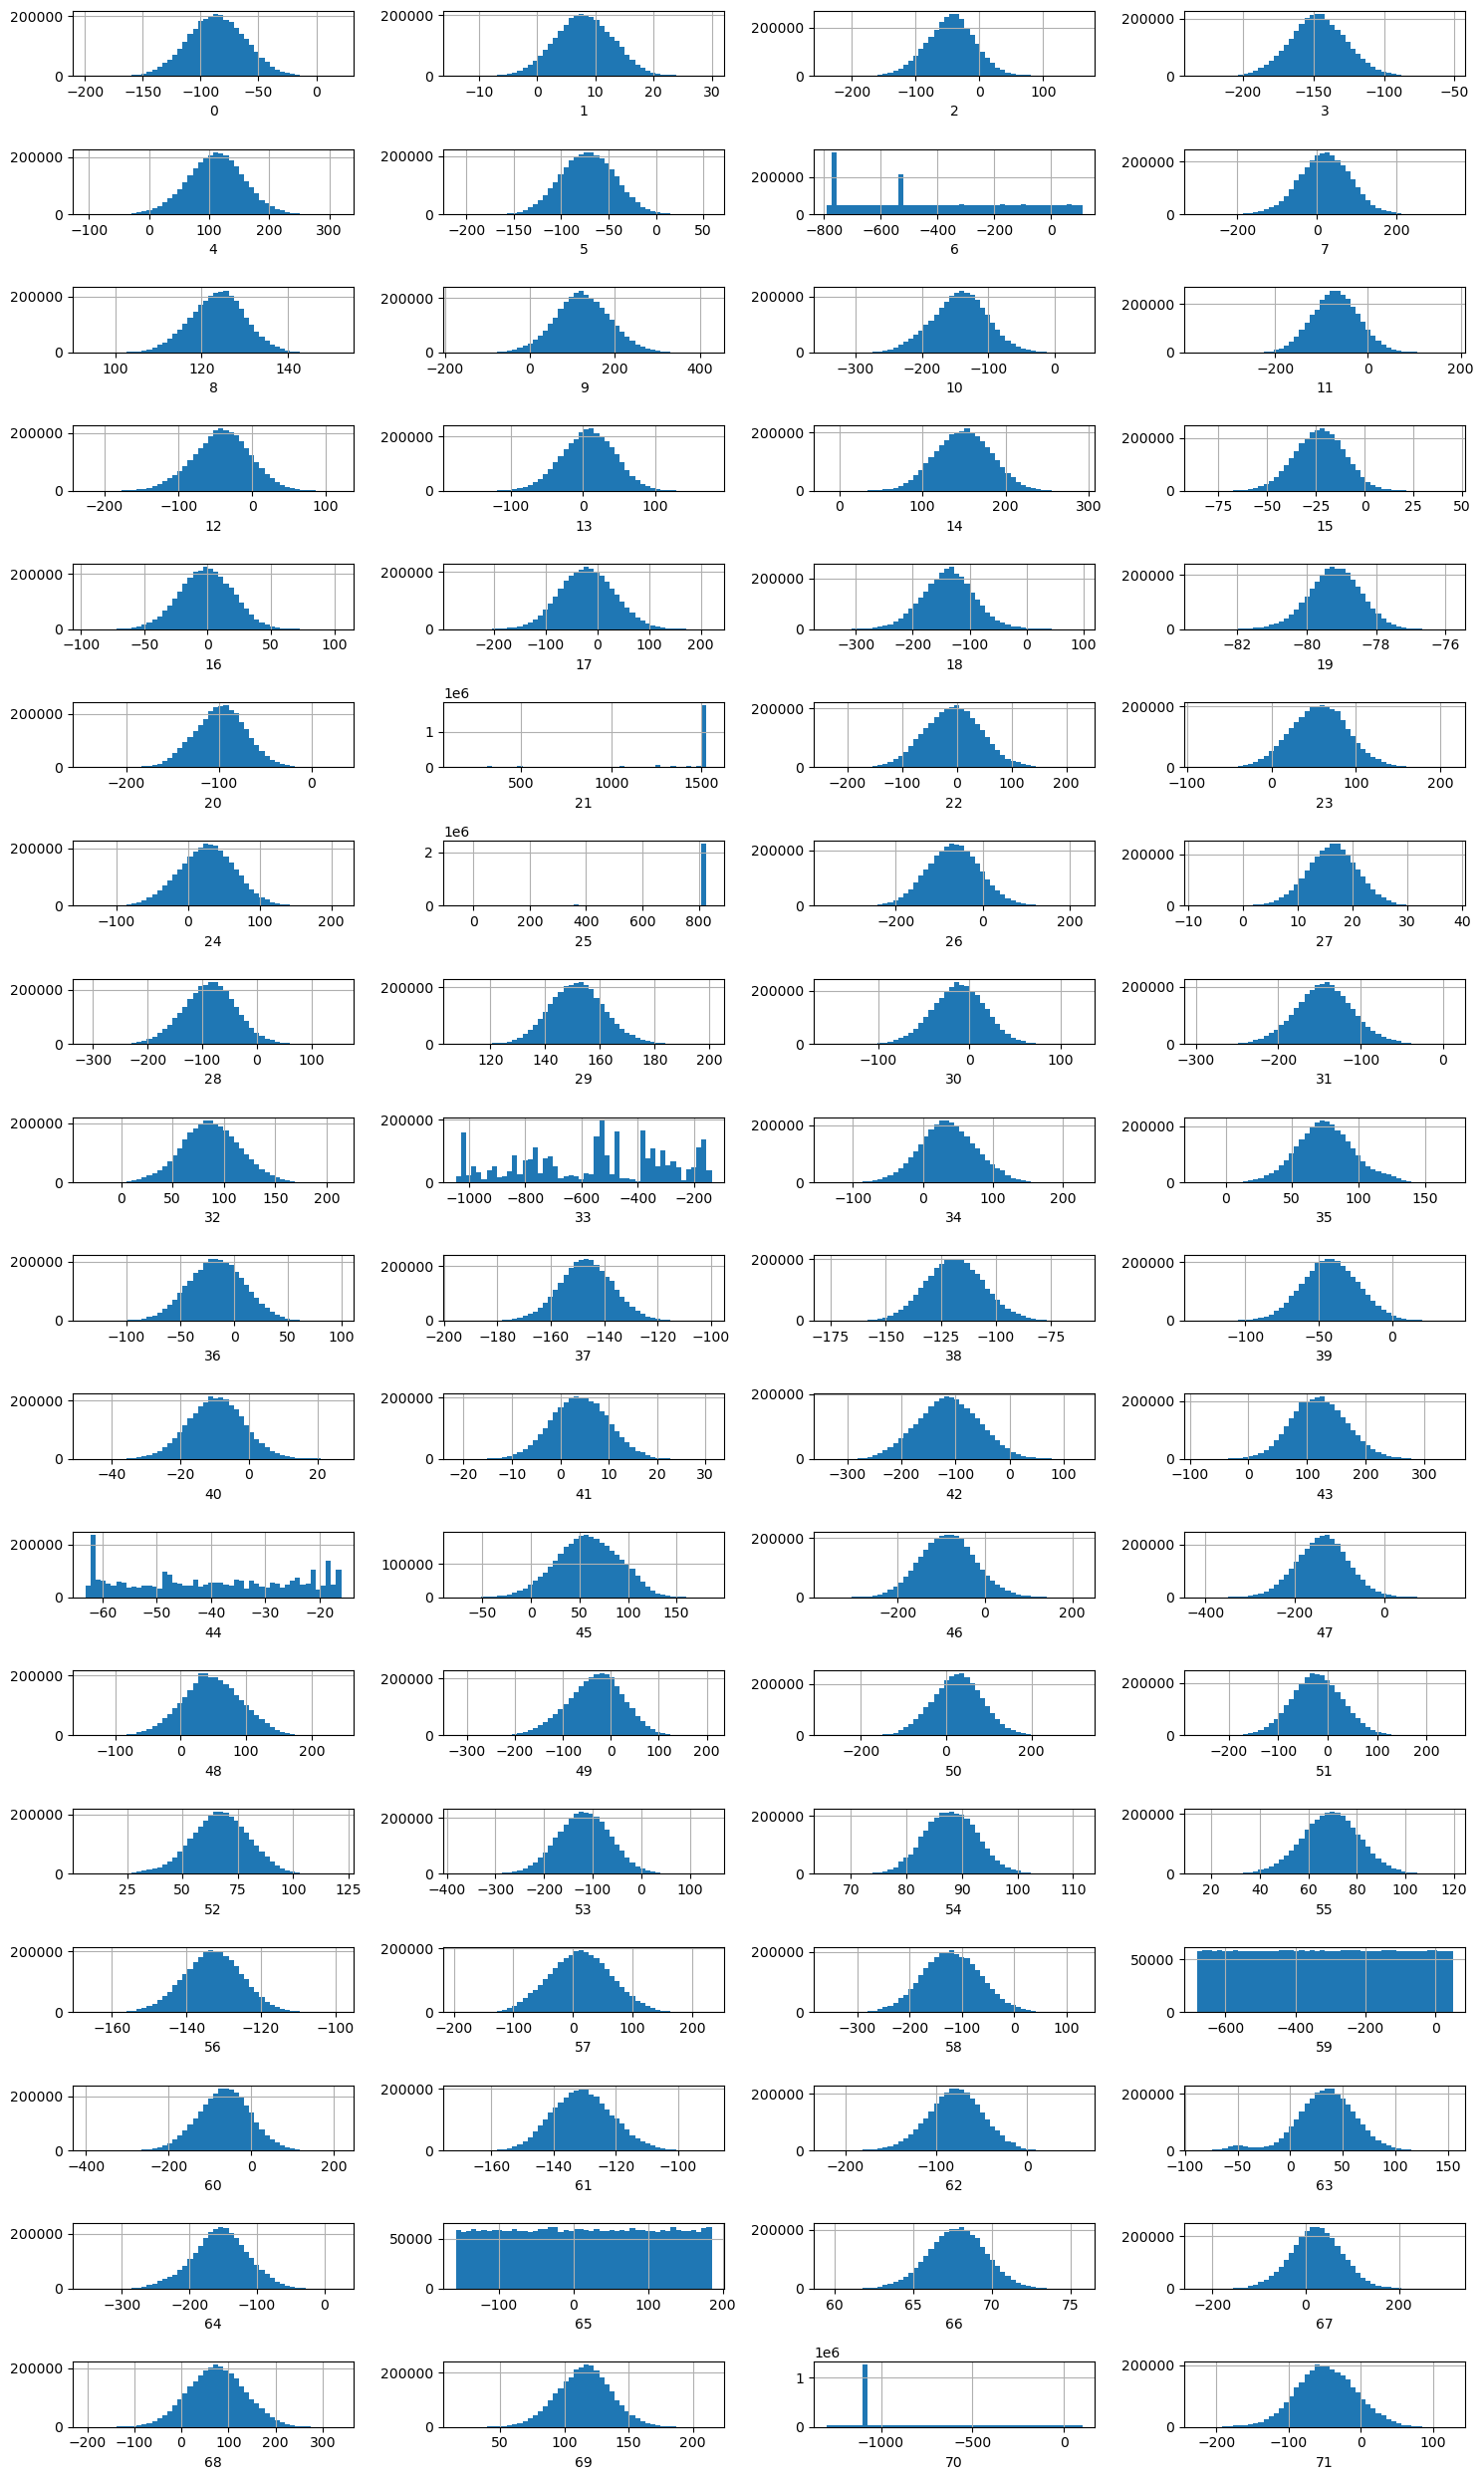

In [7]:
cols = df_base.columns

fig = plt.figure(figsize=(15,25))
for i in range(len(cols)):
    fig.add_subplot(18, 4, i+1)
    plt.hist(df_base[cols[i]], bins=50)
    plt.xlabel(cols[i])
    plt.tight_layout()
    plt.grid(True);   

Большинство данных имеют вид нормального распределения или очень схожего. В каждой колонке свой диапазон значений (широкий/узкий), встречаются как положительные та и отрицательные значения. Отдельное внимание стоит уделить столбцам №№ 6, 21, 25, 33, 44, 45, 59, 65, 70

Для детального анализа конкретных колонок ниже описана функция, которая выводит top-5 популярных значений (и частоту их повторений), а так же графики распределения этих значений в разных масштабах (общий и увеличенный).

In [8]:
# Функция для подробного анализа значений колонки

def value_analysis(dataframe, column:str, ylim_max:float, color='blue'):
    print('Наиболее популярные значения, %')
    display((dataframe[column].value_counts(normalize=True)
                              .sort_values(ascending=False)*100)
                              .to_frame()
                              .rename(columns={column:'values','proportion':'frequency, %'})
                              .head())

    fig, axs = plt.subplots(1, 2, figsize=(18, 6))
    axs[0].plot((dataframe[column].value_counts(normalize=True).sort_index() * 100), marker='.', linestyle='', color=color)
    axs[0].set_title('График распределения значений колонки №' + column + ' (общий вид)')
    axs[0].set_ylabel('Доля объектов от общего количества, %')
    axs[0].set_xlabel('Значения признака №' + column)
    axs[0].grid()

    axs[1].plot((dataframe[column].value_counts(normalize=True).sort_index() * 100), marker='o', linestyle='', color=color)
    axs[1].set_title('График распределения значений колонки №' + column + ' (увеличенный вид)')
    axs[1].set_ylabel('Доля объектов от общего количества, %)')
    axs[1].set_xlabel('Значения признака №' + column)
    axs[1].set_ylim(0, ylim_max)
    axs[1].grid()
    plt.show()

In [9]:
df_base_ = df_base.copy()
for df in [df_base_]:
    df.columns = df.columns.astype(str)

Наиболее популярные значения, %


values
-759.626065  9.838119
-530.124724  5.647949
-175.047853  0.127033
-92.055125   0.124120
-750.151074  0.091120

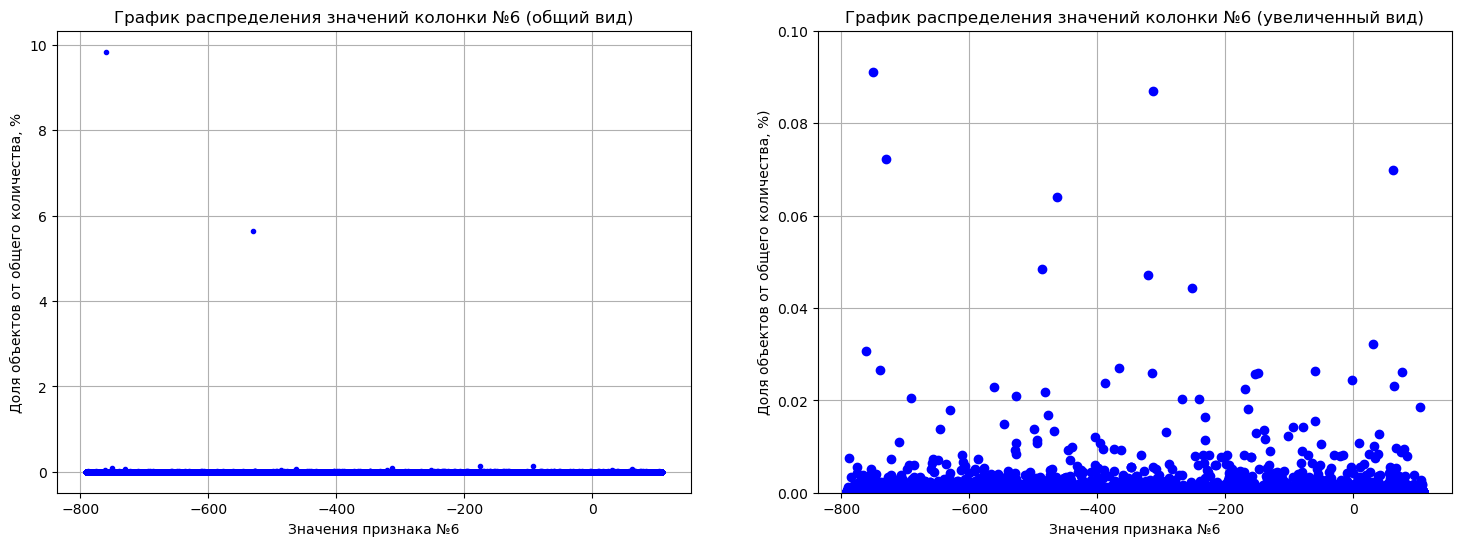

In [10]:
# распределение значений колонки №6
value_analysis(df_base_, '6', 0.1)

Пара значений (-759.626065, -530.124724) особо выделяются. Они встречаются почти у 10% и 5% товаров, соответственно. Остальные значения не выделяются особой популярностью, и распределены равномерно на протяжении всего диапазона.

Наиболее популярные значения, %


values
1507.231274  59.214486
1248.126198   1.397603
1342.641120   1.128562
1483.714136   0.804828
1054.205600   0.683689

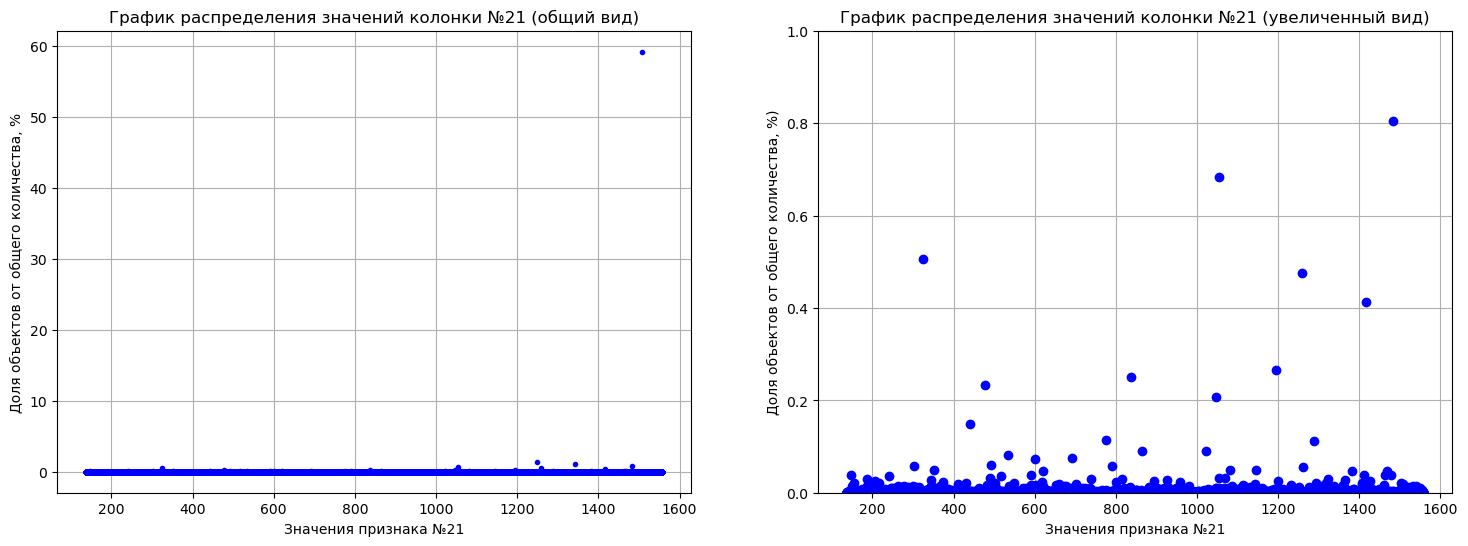

In [11]:
# распределение значений колонки №21
value_analysis(df_base_, '21', 1)

Значений 1507.231274 особо популярно, встречается у ~60%. Остальные значения не популярны. Это отчётливо видно на графиках. В том числе их равномерное распределение на протяжении всего диапазона.

Наиболее популярные значения, %


values
813.770071  79.626776
366.779583   1.480670
175.595709   0.225658
514.955051   0.045543
701.226241   0.042150

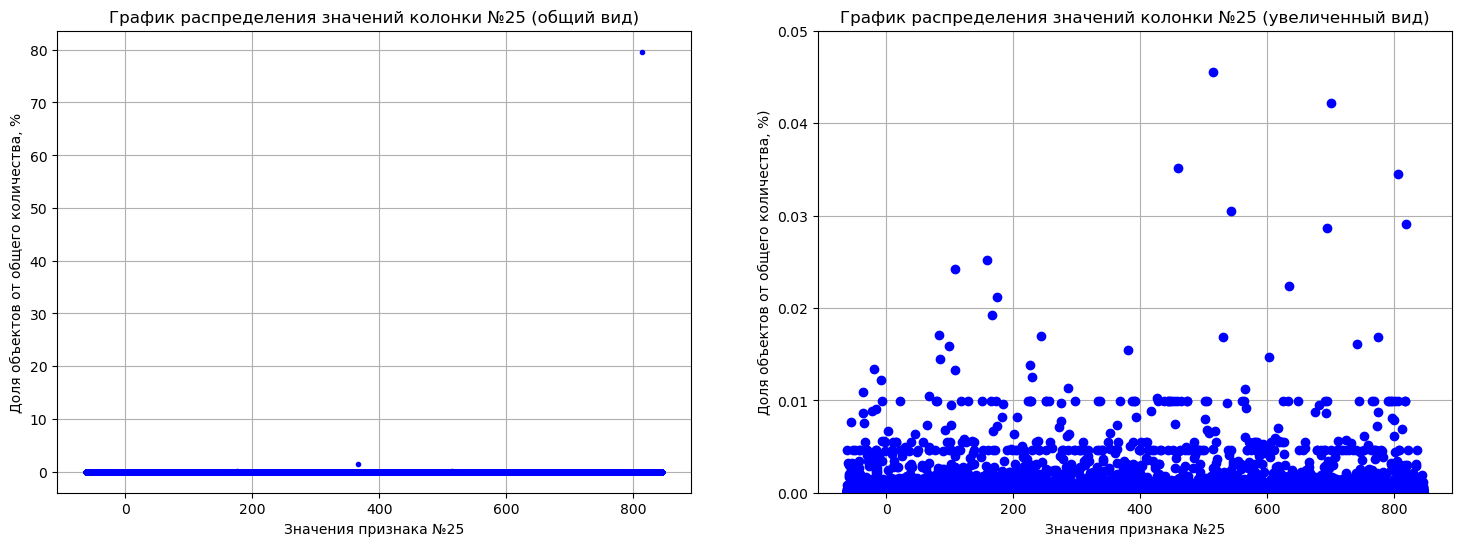

In [12]:
# распределение значений колонки №25
value_analysis(df_base_, '25', 0.05)

Пара значений (813.770071, 813.770071) особо выделяются. Они встречаются почти у 80% и 1,5% товаров, соответственно. Остальные значения не выделяются особой популярностью, и распределены равномерно на протяжении всего диапазона. На увеличенном графике (справа) прослеживается явная закономерность. Некоторые значения встречаются с равной частотой. Возможно, это закодированный цвет товара.

Наиболее популярные значения, %


values
-529.295053   6.270606
-156.249890   4.258091
-1018.469545  4.166183
-537.183707   3.761404
-481.586956   3.420742

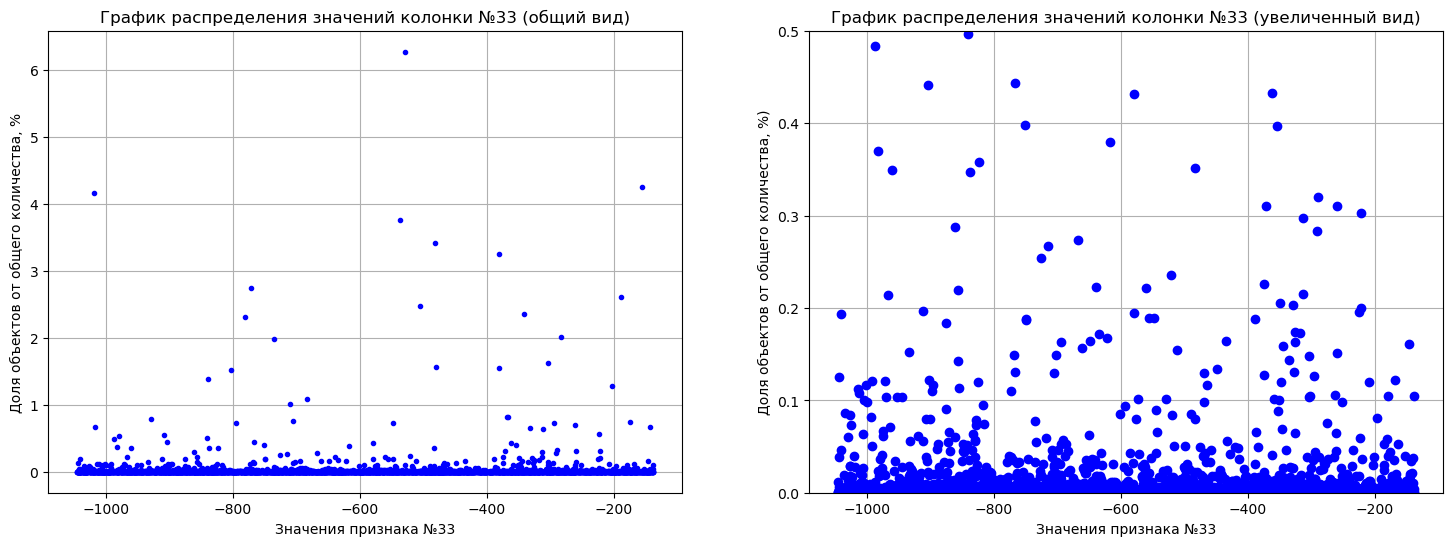

In [13]:
# распределение значений колонки №33
value_analysis(df_base_, '33', 0.5)

Аналогичная ситуация. Пара популярных значений, а все остальные равномерно распределены по всему диапазону.

Наиболее популярные значения, %


values
-61.441417  6.209197
-18.251750  3.321226
-47.166102  1.526212
-16.440254  1.192849
-21.092403  0.965958

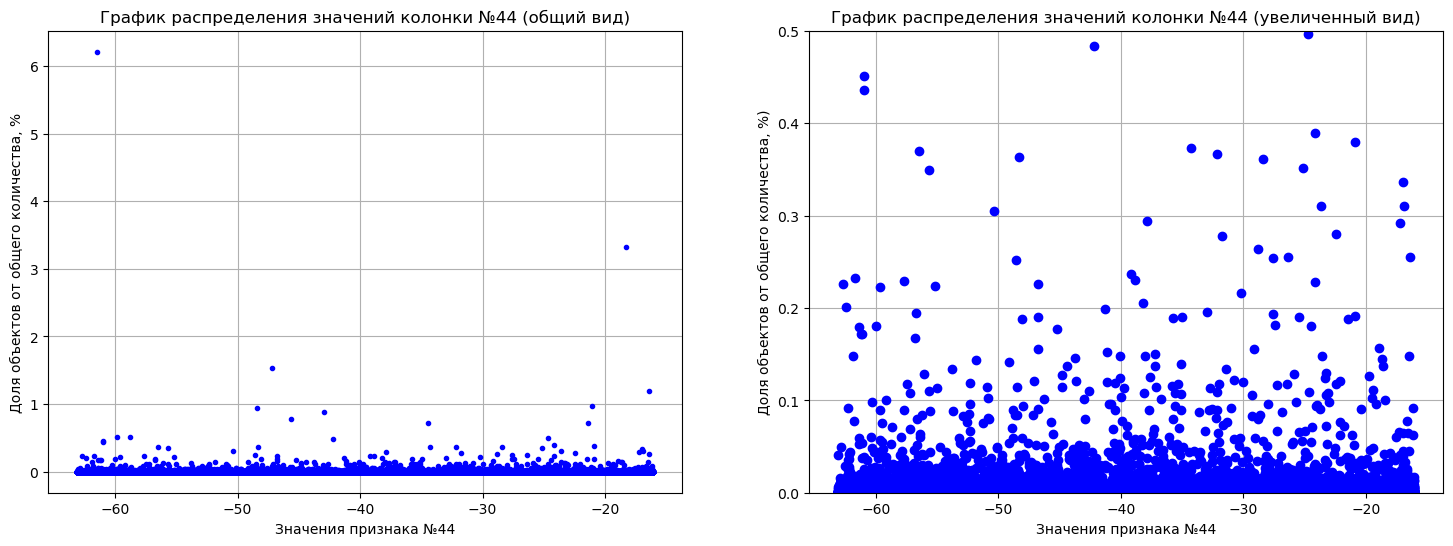

In [14]:
# распределение значений колонки №44
value_analysis(df_base_, '44', 0.5)

Аналогичная ситуация. Пара популярных значений, а все остальные равномерно распределены по всему диапазону.

Значения встречающиеся в колонке №56: [   5.14971423 -251.95235755 -529.39695637 ... -509.1430963  -268.43850644
 -409.24383652] 

Соотношение товаров и уникальность значений их параметра №59
        59
1  2913989
2     2075
Наиболее популярные значения, %


values
-230.403784  0.000069
-13.211805   0.000069
-82.038490   0.000069
-188.534014  0.000069
-651.846315  0.000069

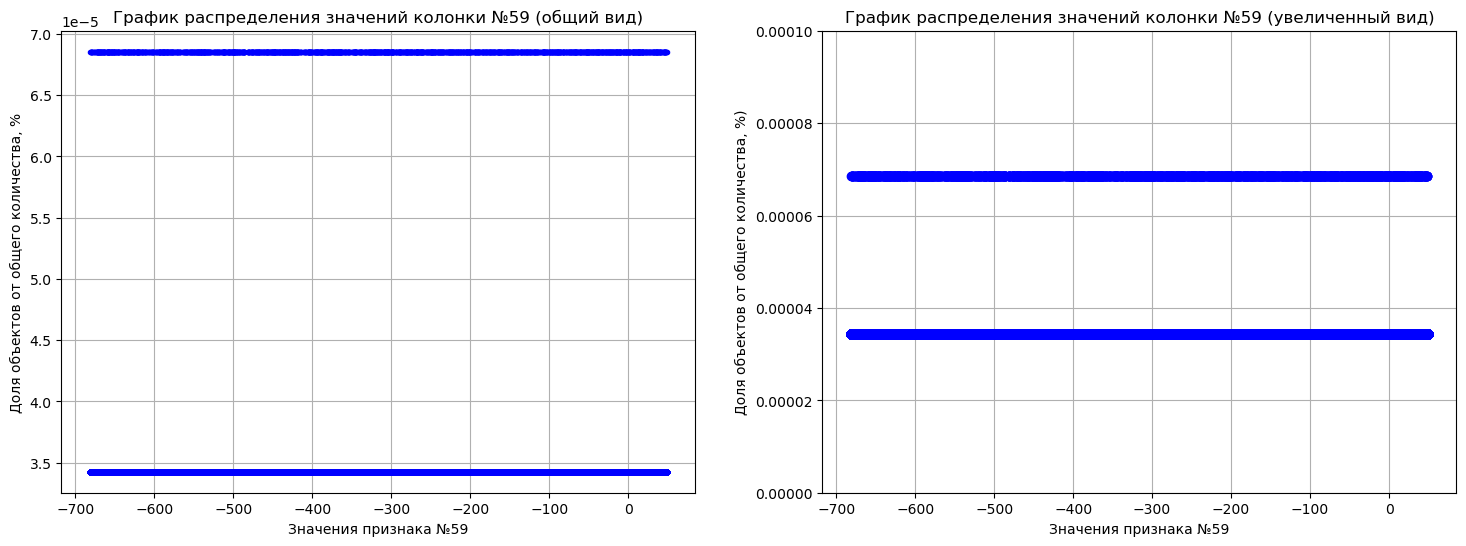

In [15]:
# анализ колонки №59
print('Значения встречающиеся в колонке №56:', df_base_['59'].unique(), '\n')

print('Соотношение товаров и уникальность значений их параметра №59')
print(df_base_['59'].value_counts().sort_values(ascending=False).value_counts().
      to_frame().rename(columns={'count':'кол-во товаров'}))

value_analysis(df_base_, '59', 0.0001)

Почти у каждого товара этот параметр уникальный и не повторяется.

Наиболее популярные значения, %


values
-21.533007   0.113703
 181.959582  0.091085
-81.475771   0.081113
 182.446349  0.070696
 130.450168  0.066207

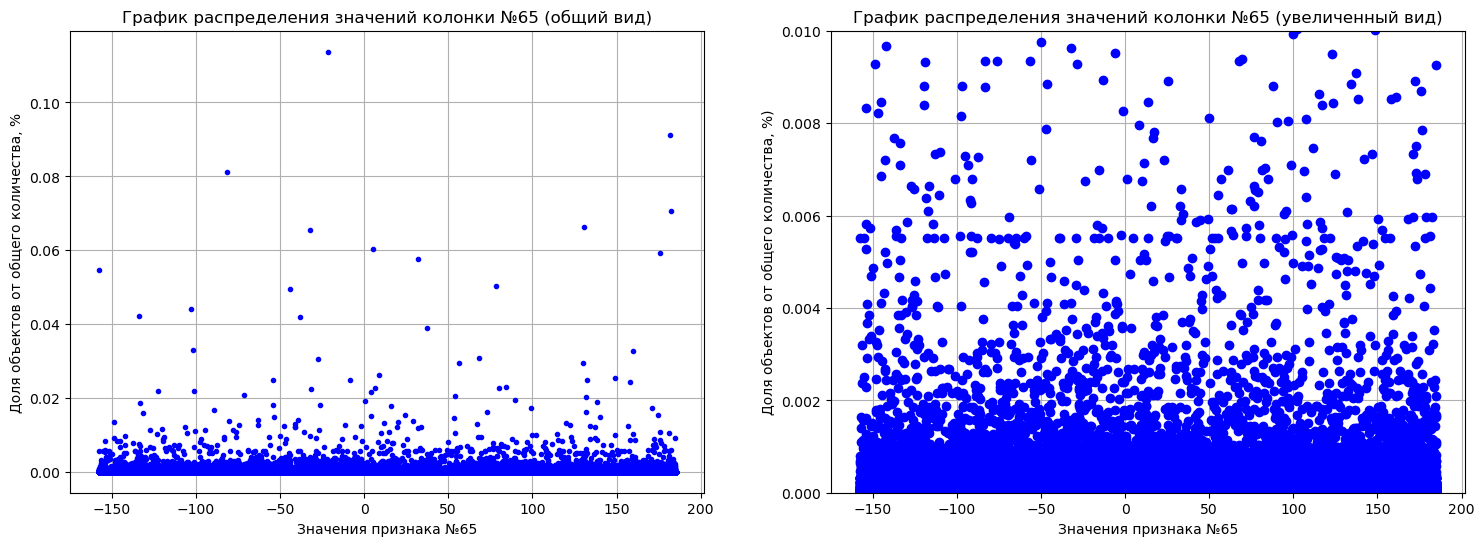

In [16]:
# распределение значений колонки №65
value_analysis(df_base_, '65', 0.01)

Равномерное распределение значений, за редкими исключениями определённых значений

Наиболее популярные значения, %


values
-1074.464888  41.923877
-782.676180    0.235321
-597.491204    0.028957
-799.363667    0.005106
-891.219087    0.005072

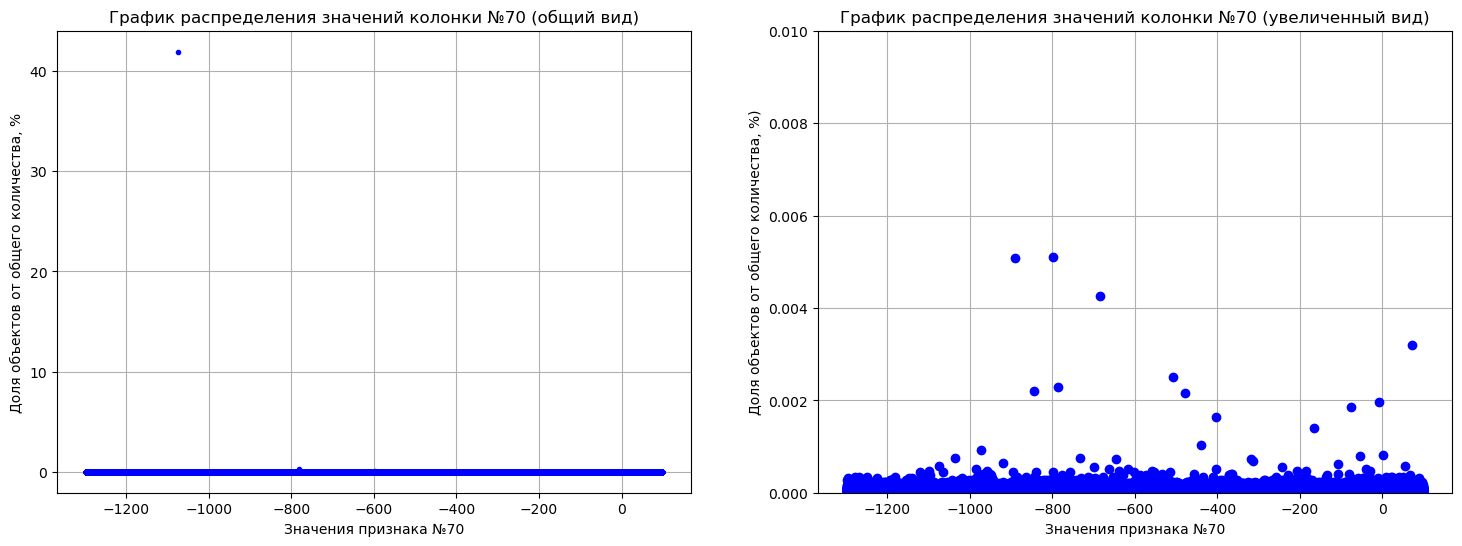

In [17]:
# распределение значений колонки №70
value_analysis(df_base_, '70', 0.01)

Особо популярное значение (-1074.464888) встречающее более чем у 40% товаров. Остальные значения распределены равномерно на протяжении всего диапазона. На увеличенном графике (справа) прослеживается явная дискретность частоты повторения значений.

Общий вывод по данным: значения распределены равномерно. Выбросы отсутствуют.

In [18]:
df_base.head()

0          1          2          3           4           5  \
Id                                                                            
0-base -115.083890  11.152912 -64.426760 -118.88089  216.482440 -104.698060   
1-base  -34.562202  13.332763 -69.787610 -166.53348   57.680607  -86.098370   
2-base  -54.233746   6.379371 -29.210136 -133.41383  150.895830  -99.435326   
3-base  -87.520130   4.037884 -87.803030 -185.06763   76.369540  -58.985165   
4-base  -72.743850   6.522049  43.671265 -140.60803    5.820023 -112.074080   

                 6          7           8           9  ...          62  \
Id                                                     ...               
0-base -469.070588  44.348083  120.915344  181.449700  ...  -42.808693   
1-base  -85.076666 -35.637436  119.718636  195.234190  ... -117.767525   
2-base   52.554795  62.381706  128.951450  164.381470  ...  -76.397800   
3-base -383.182845 -33.611237  122.031910  136.233580  ...  -70.647940   
4-base -397.711282  45.182500  122.167180  112.119064  ...  -57.199104   

               63         64          65        66         67          68  \
Id                                                                          
0-base  38.800827 -151.76218  -74.389090  63.66634  -4.703861   92.933610   
1-base  41.100000 -157.82940  -94.446806  68.20211  24.346846  179.937930   
2-base  46.011803 -207.14442  127.325570  65.56618  66.325680   81.073490   
3-base  -6.358921 -147.20105  -37.692750  66.20289 -20.566910  137.206940   
4-base  56.642403 -159.35184   85.944724  66.76632  -2.505783   65.315285   

                69           70         71  
Id                                          
0-base  115.269190  -112.756640 -60.830353  
1-base  116.834000   -84.888941 -59.524610  
2-base  116.594154 -1074.464888 -32.527206  
3-base  117.474100 -1074.464888 -72.915490  
4-base  135.051590 -1074.464888   0.319401  

[5 rows x 72 columns]

Значения положительные и отрицательные. От нескольних десяткой в максимуме, до нескольких сотен. Нужно провести масштабирование.

In [19]:
# Применим StandardScaler:
scaler = StandardScaler()
df_base = pd.DataFrame(scaler.fit_transform(df_base), index=df_base.index)
df_base.head()

0         1         2         3         4         5         6   \
Id                                                                             
0-base -1.159216  0.620350 -0.513723  1.398558  2.269043 -1.160385 -0.282884   
1-base  2.075715  1.060423 -0.652491 -1.002705 -1.157244 -0.500495  1.130652   
2-base  1.285417 -0.343342  0.397878  0.666228  0.853956 -0.973671  1.637293   
3-base -0.051852 -0.816047 -1.118829 -1.936660 -0.754014  0.461441  0.033281   
4-base  0.541780 -0.314538  2.284450  0.303705 -2.276181 -1.422075 -0.020200   

              7         8         9   ...        62        63        64  \
Id                                    ...                                 
0-base  0.373663 -0.435627  0.884544  ...  1.189049  0.190524  0.073589   
1-base -0.871900 -0.623903  1.098487  ... -1.272135  0.270119 -0.073569   
2-base  0.654489  0.828686  0.619635  ...  0.086191  0.440159 -1.269686   
3-base -0.840347 -0.259958  0.182763  ...  0.274980 -1.372853  0.184217   
4-base  0.386656 -0.238677 -0.191508  ...  0.716557  0.808178 -0.110496   

              65        66        67        68        69        70        71  
Id                                                                            
0-base -0.894789 -2.262493 -0.510438  0.293004 -0.014051  1.781420 -0.312329  
1-base -1.097493  0.225102  0.014491  1.711283  0.059848  1.853726 -0.281052  
2-base  1.143739 -1.220546  0.773022  0.099669  0.048521 -0.713847  0.365623  
3-base -0.523936 -0.871349 -0.797073  1.014714  0.090076 -0.713847 -0.601807  
4-base  0.725544 -0.562342 -0.470720 -0.157210  0.920175 -0.713847  1.152406  

[5 rows x 72 columns]

#### Создание индексов с FAISS:

Принцип работы [Faiss](https://faiss.ai/index.html):
1. Отображение всех объектов (векторов) в едином пространстве
2. Деление полученного пространства на отдельные части (кластеры) при помощи спец. алгоритма библиотеки
3. Для каждого кластера происходит поиск его центра (центроида)
4. Таким образом, для нового вектора можно быстрой найти ближайших соседей, вычислив расстояние именно до центроидов (не перемножая новый вектор со всеми остальными векторами).
5. После выявления ближайшего кластера, новый вектор перемножается векторами только из этого кластера.

`FlatL2` - мера близости вектором L2-норма (евклидово расстояние). По этой причине большое значение имеет "нормализованы ли признаки?", поскольку в этой ситуации признак бóльшей величины будет играть бóльшую роль в предсказании. Но это не отображает достоверность его значимость.

`quantizer` - квантизатор, который получает на вход вектора размерностью `dims` и рассчитывает расстояние между ними по евклидовой норме.

`idx_l2` - пространство векторов размерностью `dims`, разделяемое на фиксированное кол-во кластеров из `n_cells` с помощью `quantizer`.

In [20]:
dims = df_base.shape[1]
n_cells = 1000 # # кол-во кластеров для деления векторного пространства. Подбор произведен в train разделе.
n_neigbours = 30 # кол-во ближайших соседей
quantizer = faiss.IndexFlatL2(dims)
idx_l2 = faiss.IndexIVFFlat(quantizer, dims, n_cells)
idx_l2.nprobe = 200

значение n_neighbours равно 30 из-за нехватки оперативной памяти на локальном компьютере. Рекомендуемое значение >= 100

Функция `np.ascontiguousarray()` располагает последовательно весь массив данных в оперативной памяти.

In [21]:
idx_l2.train(np.ascontiguousarray(df_base).astype('float32'))
idx_l2.add(np.ascontiguousarray(df_base.values).astype('float32'))

In [22]:
# Словарь id и номеров векторов:
base_index = {k: v for k, v in enumerate(df_base.index.to_list())}

print('Пример содержания словаря:\n', list(base_index.items())[0:3])

Пример содержания словаря:
 [(0, '0-base'), (1, '1-base'), (2, '2-base')]


In [23]:
# Сохранянем:
with open(PATH + 'base_index.txt', 'w') as convert_file:
     convert_file.write(json.dumps(base_index))

### train.csv & validation.csv

In [24]:
# Открываем и сохраняем файл train.csv & validation.csv,validation_answer.csv в датафреймы из директории:
df_train = pd.read_csv(PATH + 'train.csv', index_col=0)
targets_train = df_train["Target"]
targets_valid = pd.read_csv(PATH + 'validation_answer.csv', index_col=0)['Expected']
# Применяем scaler:
df_train.drop("Target", axis=1, inplace=True)
df_train = pd.DataFrame(scaler.transform(df_train), index=df_train.index)
df_valid = pd.read_csv(PATH + 'validation.csv', index_col=0)
df_valid = pd.DataFrame(scaler.transform(df_valid), index=df_valid.index)

In [25]:
# Проверка на пропуски в данных:
df_train.isna().sum()

0     0
1     0
2     0
3     0
4     0
     ..
67    0
68    0
69    0
70    0
71    0
Length: 72, dtype: int64

In [26]:
df_valid.isna().sum()

0     0
1     0
2     0
3     0
4     0
     ..
67    0
68    0
69    0
70    0
71    0
Length: 72, dtype: int64

In [27]:
# Проверим данные на дубли:
df_train.duplicated().sum(), df_valid.duplicated().sum()

(0, 0)

Пропусков и дубликатов в данных нет

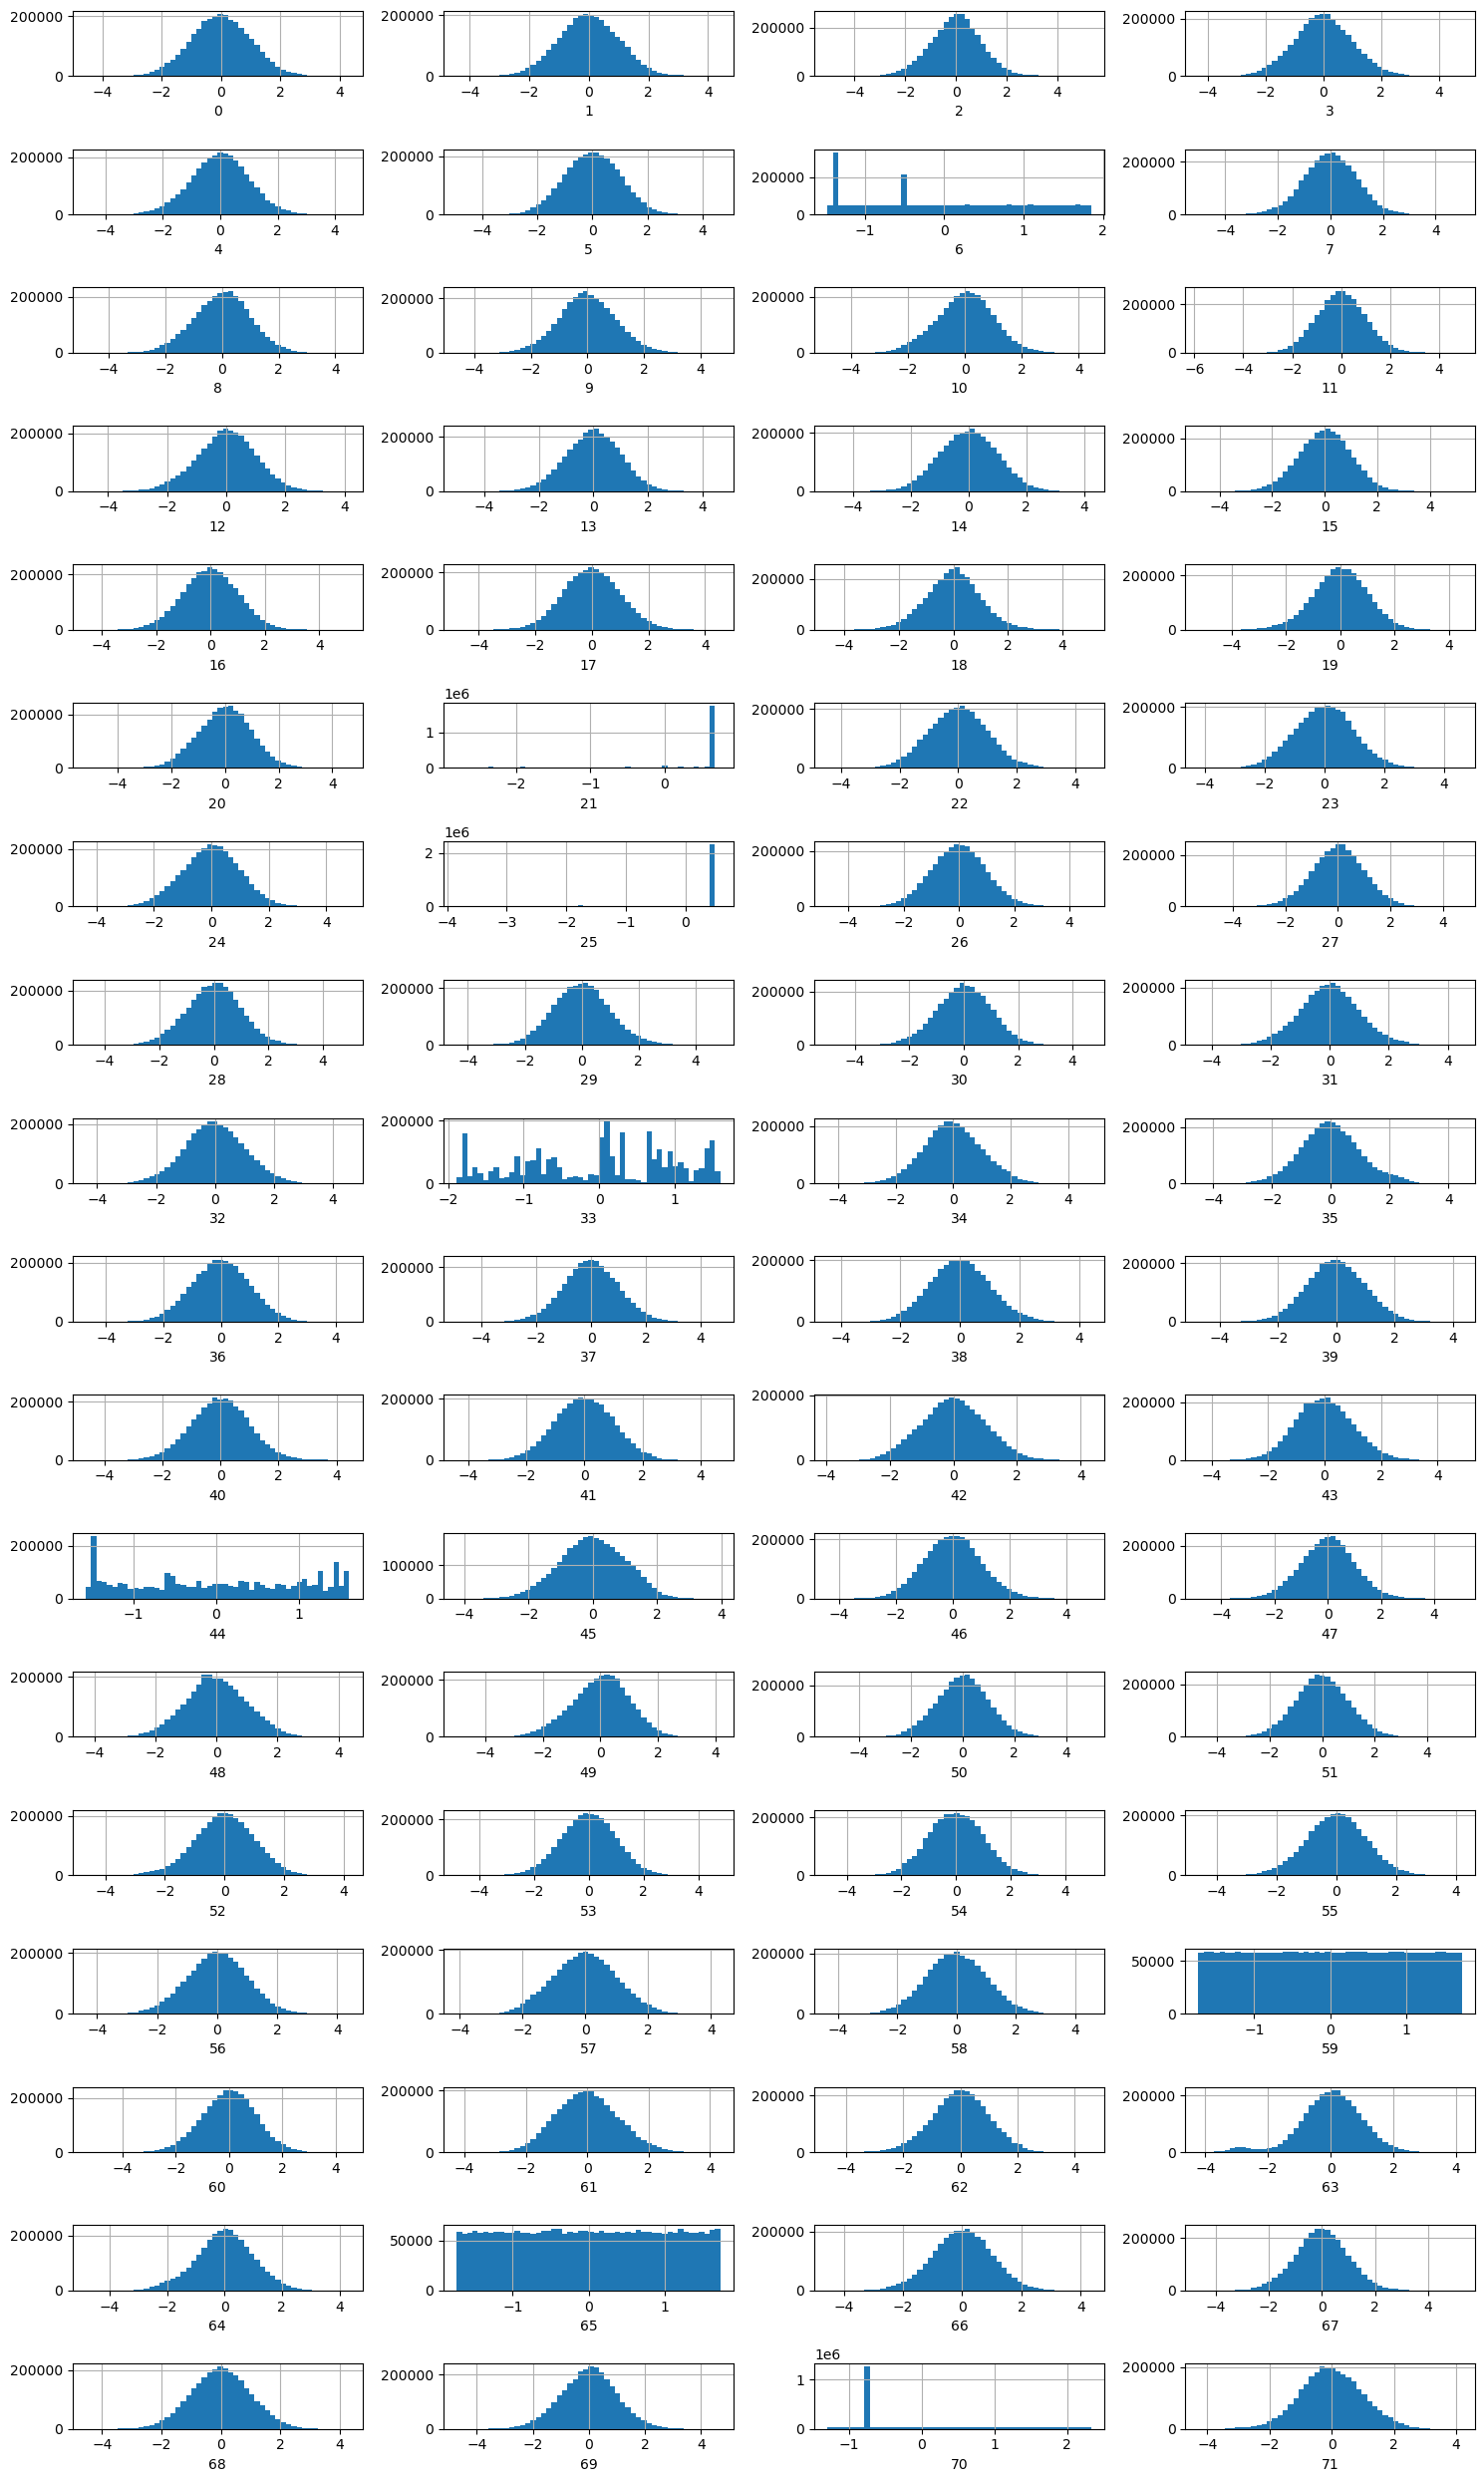

In [28]:
cols = df_train.columns

fig = plt.figure(figsize=(15,25))
for i in range(len(cols)):
    fig.add_subplot(18, 4, i+1)
    plt.hist(df_base[cols[i]], bins=50)
    plt.xlabel(cols[i])
    plt.tight_layout()
    plt.grid(True);    

распределение данных такое же, как и в `base`

In [29]:
df_train.head()

0         1         2         3         4         5         6   \
Id                                                                              
0-query  1.299519  1.996888  0.063774 -1.879671  1.644100 -0.537626  0.165148   
1-query -0.062146 -0.257159  0.324249 -1.543245  0.204684 -0.419328  1.095696   
2-query  1.456328 -0.855696 -1.851792 -1.701553  1.700433  0.750504  1.543015   
3-query  1.543467  0.203199 -1.833235  1.291201 -0.359536 -1.322073 -1.409605   
4-query  0.265046  1.284537 -0.370748 -0.021041 -1.169187  1.977993  0.261015   

               7         8         9   ...        62        63        64  \
Id                                     ...                                 
0-query  0.279598 -2.296794 -1.459626  ... -0.866975  1.274319 -0.024410   
1-query -1.538329  0.193777  0.246358  ...  1.254600 -0.991073  0.075152   
2-query -0.791080  0.328335  1.352615  ...  0.886224  1.548929 -0.348054   
3-query  0.916179  0.050167  1.834418  ...  0.573141  0.388351  0.227494   
4-query  0.399148  0.355099 -0.326947  ...  0.336621  0.406133 -1.001615   

               65        66        67        68        69        70        71  
Id                                                                             
0-query -1.173481 -1.035388  0.197184 -0.200786  0.906575  0.995267  0.522963  
1-query -0.159574  0.207972  0.028031  0.244774  0.709459 -0.611690 -0.083491  
2-query  0.687136 -0.978114 -0.092956  2.240614  0.300576 -0.713847  0.604677  
3-query  0.806859 -2.007464  1.491032  0.133987  0.128028 -0.713847  0.668019  
4-query -1.331745 -0.474647  0.341715  0.043401 -1.090276 -0.713847  0.638160  

[5 rows x 72 columns]

Признаков достаточно много. Посмотрим на вклад признаков в дисперсию. Применим PCA

In [30]:
pca = PCA(n_components=72)
pca.fit_transform(df_train)
prop_var = pca.explained_variance_ratio_
eigenvalues = pca.explained_variance_
prop_var

array([0.01973374, 0.01816645, 0.01730493, 0.01715116, 0.01704777,
       0.01666542, 0.01647463, 0.01641761, 0.01627893, 0.01620418,
       0.01606427, 0.01604147, 0.0158648 , 0.01580805, 0.01568574,
       0.01551171, 0.01547863, 0.01534147, 0.01527404, 0.01513032,
       0.01507609, 0.01495186, 0.01485907, 0.01478718, 0.01471094,
       0.0146042 , 0.01451426, 0.01449566, 0.01443599, 0.0143704 ,
       0.01427519, 0.01409503, 0.01407072, 0.01405818, 0.01391499,
       0.01383049, 0.01377686, 0.01370164, 0.01368139, 0.01358596,
       0.01358014, 0.0134809 , 0.01341096, 0.01338323, 0.01334044,
       0.01319322, 0.01310197, 0.01302713, 0.01297026, 0.01288826,
       0.01273583, 0.01270684, 0.0126214 , 0.01249263, 0.01242751,
       0.01235725, 0.01218494, 0.01208805, 0.01207162, 0.01187485,
       0.01185562, 0.01179414, 0.01166108, 0.01149027, 0.01128657,
       0.01116764, 0.01098165, 0.01086977, 0.01039083, 0.0102867 ,
       0.00984082, 0.00899603])

Построим график доли объясненной дисперсии.

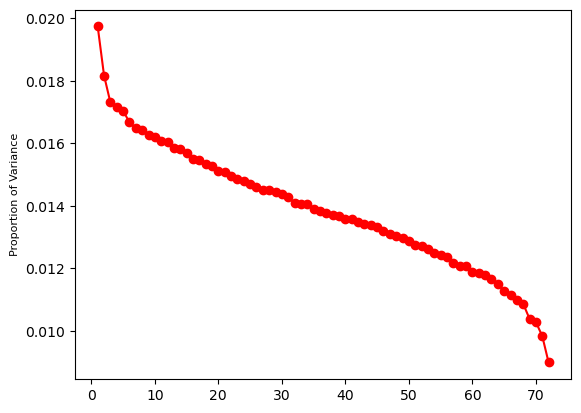

In [31]:
PC_numbers = np.arange(pca.n_components_) + 1
 
plt.plot(PC_numbers, 
         prop_var, 
         'ro-')
plt.ylabel('Proportion of Variance', fontsize=8)
plt.show()

Лишь 1 признак вносит около 2%. Остальные около 1,5 а некоторые и менее. Попробуем найти `accuracy@5` со всеми признаками.

In [32]:
# Подбор кол-ва кластеров методом локтя на train:
#distortions = []
inertias = []
#mapping1 = {}
#mapping2 = {}
K = range(1, 5000,500)
 
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(df_train)
    kmeanModel.fit(df_train)
 
#   distortions.append(sum(np.min(cdist(df_train, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / df_train.shape[0])

    inertias.append(kmeanModel.inertia_)
 
#    mapping1[k] = sum(np.min(cdist(df_train, kmeanModel.cluster_centers_,
#                                   'euclidean'), axis=1)) / df_train.shape[0]
#    mapping2[k] = kmeanModel.inertia_

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` exp

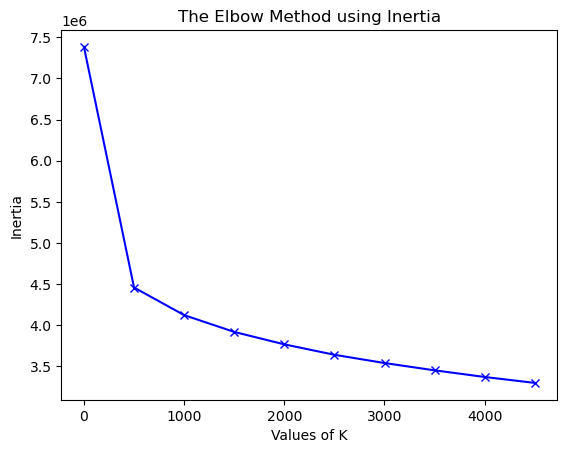

In [33]:
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

Выберем 1000 кластеров для деления векторного пространства.

**Корреляция**

Проверим наличие зависимости между признаками, к примеру линейной и квадратичной. За это отвечают коэффициенты корреляции Пирсона и Фик, соответственно.

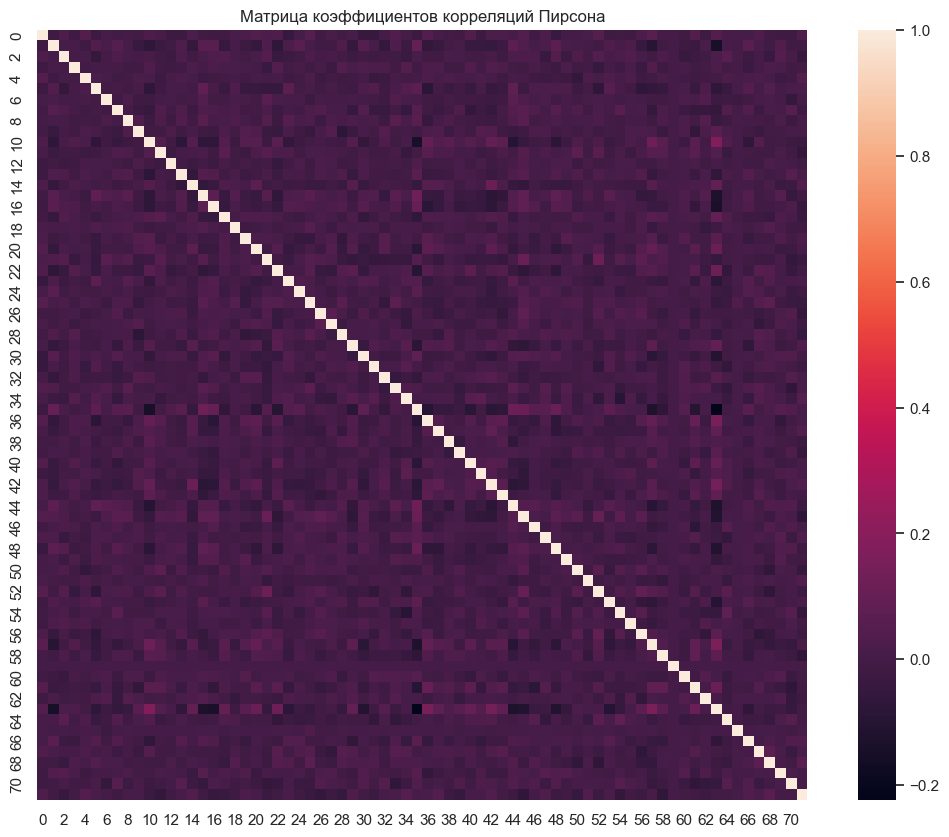

In [34]:
# корреляций Пирсона
sns.set(rc = {'figure.figsize':(13, 10)})
sns.heatmap(df_base.corr(), square=True)
plt.title('Матрица коэффициентов корреляций Пирсона');

In [35]:
# корреляции Фик
phik_overview = df_train.phik_matrix(interval_cols=df_train.columns)

plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(90, 70))
plt.tight_layout()

Явная зависимость между признаками - отсутствует. Всех их можно считать уникальными характеристиками товара.

### Поиск кандидатов с FAISS

Функция candidate_search. Для каждого вектора из `trans_train` найди по **N** ближайших векторов из `df_base` (которые уже размечены на отдельные кластеры). Результатом являются:
- `idx` - порядковые номера ближайших векторов, и
- `distance` - расстояние между векторами.

In [36]:
def candidate_search(df, df_target):
    start = time.time()
    distances, idx = idx_l2.search(np.ascontiguousarray(df.values).astype('float32'), n_neigbours)
    print('search took {}'.format(time.time() - start))
    print('Примеры idx :\n', idx[:3], '\n')
    print('Примеры vectors :\n', distances[:3])    
    
    acc = 0
    for target, el in zip(df_target.values.tolist(), idx.tolist()):
        acc += int(target in [base_index[r] for r in el])        
    print('neighbours found: {} %'.format(100 * acc / len(idx)))
    return distances, idx

Поиск для `df_train`:

In [37]:
distances_train, idx_train = candidate_search(df_train, targets_train)

search took 359.5156469345093
Примеры idx :
 [[ 598613  755584  336969 1934845   13374 1136231  480296  583287 2360257
   450667  988777 1653095 1818641  503716 1631947   89840  143978  986050
   629775 2346335  223859  352715  455829 1747988 1674977  443428 2295048
   728097 1113711 1746258]
 [ 737853   15185  519311  902634  223456  464427  220644 2146806 2524968
   643208  134844  301385  340012  298805  216389  188242  971689  573064
  1459914  548516  924284 1010871  917176 1348395   10845 2214631 1312093
   603976  458085  780936]
 [ 173120 1784963 2863071 1143288  955831  137853 1368891 1162532  774247
  1984148 1479188 1238526 2351134  641280 1532675 1774212  948608   12304
  2395210 1905367 1341266 2642468 2475151  859626  182696 1392119 1359128
  2710601 1495133 1659033]] 

Примеры vectors :
 [[19.299538 19.4676   20.747215 23.199966 23.545164 23.618977 26.231094
  26.31761  26.3673   26.425821 26.577133 27.139736 27.454794 27.815868
  28.002186 28.126244 28.746382 28.746588 

Поиск для `df_valid`:

In [38]:
distances_valid, idx_valid = candidate_search(df_valid, targets_valid)

search took 359.0470161437988
Примеры idx :
 [[2192372 2177660  342838  574649 1954150 2363873 1225777 1405698 2910875
  1719453 2512787 2504096 1243148 2571634  536120  995930  462353  814942
  1508869 2536973 2239161  340288  106841  999102  277780 2875559 2886161
  1837653 1952068 1869523]
 [ 157966   11829  847800 1902634 2580959 2275539 2561209 2123768  138680
  2435892  374422 1459534  135315 1584915 1884931 2893838 1872797 2046243
  1256848 1187110  489609 1751144 2055627  434145 1931125 1162720 2242396
  2259158 2233171  871652]
 [ 431806  148400  451870  281105   24989  685598  365989  279417  674511
   318265  832464  195078  389136  359945  223916  208180 1706372 2154246
   677348  762361 1176289 1628321  769163 1825274 1902042 1555264 1818924
  1708048  159926 1107448]] 

Примеры vectors :
 [[ 8.076221  10.031795  13.769161  14.486227  18.285744  18.67206
  19.751312  19.939331  20.306961  20.335863  20.641088  21.0288
  21.127302  21.297255  21.913015  22.27356   22.305027

### Создание больших `all-features` датафреймов

Функция `saving_big_df`:

In [39]:
def saving_big_df(idx, distances, df, df_target, type):
    features_list = []
    target_list = []
    idx_d_list = []
    for i in tqdm(range(len(df))):
        q = [df[i] for index in idx[i]]
        p = [base[index] for index in idx[i]]
        d = [distance for distance in distances[i]]
        j = [index for index in idx[i]]
        t = np.array([1 if base_index[index] == df_target.values.tolist()[i] else 0 for index in idx[i]])
        target_list.append(t)
        features_list.append(np.concatenate((q, p), axis = 1)) 
        idx_d_list.append(np.vstack((j, d)).T)
        del q, p, t, j, d
                
    del df
    gc.collect()    
    print('lists created...')
    pd.DataFrame(np.concatenate(target_list)).to_csv(PATH + 'target_'+ type + '.csv')
    del target_list
    print('targets saved...')
    pd.DataFrame(np.concatenate(idx_d_list)).to_csv(PATH + 'faiss_idx_and_distances_'+ type + '.csv')
    del idx_d_list
    print('indexes ad distances saved...')
    pd.DataFrame(np.concatenate(features_list)).to_csv(PATH + 'all_features_'+ type + '.csv')
    del features_list
    print('features saved!')
    gc.collect()

In [40]:
base = np.array(df_base.reset_index(drop=True))
train = np.array(df_train)
valid = np.array(df_valid)

In [41]:
del df_base
del df_train
del df_valid
gc.collect()

0

***Сохранение train `all-features`:***

In [42]:
saving_big_df(idx_train, distances_train, train, targets_train, 'train')

  0%|          | 0/100000 [00:00<?, ?it/s]

lists created...
targets saved...
indexes ad distances saved...
features saved!


***Сохранение valid `all-features`:***

In [43]:
saving_big_df(idx_valid, distances_valid, valid, targets_valid, 'valid')

  0%|          | 0/100000 [00:00<?, ?it/s]

lists created...
targets saved...
indexes ad distances saved...
features saved!


## Загрузка данных train

In [44]:
features_train = pd.read_csv(PATH + 'all_features_train.csv', index_col=0)
target_train = pd.read_csv(PATH + 'target_train.csv', index_col=0)
idx_d_train = pd.read_csv(PATH + 'faiss_idx_and_distances_train.csv', index_col=0)

In [45]:
features_train['distance'] = idx_d_train['1']
features_train['index'] = idx_d_train['0']
features_train['target'] = target_train

### GridSearch

Поиск наилучших параметров на стратифицированной выборке (20% данных train)

In [46]:
N = len(features_train)*0.2
sample = features_train.groupby('target', group_keys=False).\
                        apply(lambda x: x.sample(int(np.rint(N*len(x)/len(features_train))))).\
                        sample(frac=1).reset_index(drop=True)

In [47]:
y_sample = np.array(sample['target'])
X_sample = np.array(sample.drop(['target'], axis = 1))

In [48]:
X_sample_train, X_sample_test, y_sample_train, y_sample_test = train_test_split(X_sample, y_sample, 
                                                    test_size=0.2,                         
                                                    random_state=13425,
                                                   stratify=y_sample)
print(X_sample_train.shape)
print(X_sample_test.shape)

(480000, 146)
(120000, 146)


In [49]:
# Подбираем гиперпараметры(долго выполняется - закомментировал, подобрав grid.best_params_)
#model = CatBoostClassifier(verbose=500, iterations=1500, 
#                           random_seed=13425, 
#                           loss_function='Logloss',
#                           boosting_type='Ordered')
#
#params = {'depth': range (3, 10)}
#
#grid = GridSearchCV(model, params, scoring='f1') 
#grid.fit(train_sample.drop(['target'], axis = 1), train_sample['target'])
#f1 = grid.best_score_
#print('F1 on stratified sample:', round(f1, 3))
#print(grid.best_params_)

In [50]:
model = CatBoostClassifier(verbose=500, depth=6, 
                           iterations=1500, 
                           random_seed=13425, 
                           loss_function='Logloss',
                           boosting_type='Ordered')
model.fit(X_sample_train, y_sample_train)

Learning rate set to 0.099163
0:	learn: 0.5235435	total: 551ms	remaining: 13m 45s
500:	learn: 0.0347364	total: 3m 5s	remaining: 6m 10s
1000:	learn: 0.0320766	total: 5m 51s	remaining: 2m 55s
1499:	learn: 0.0318426	total: 7m 59s	remaining: 0us


функция `metrics`:

In [51]:
import matplotlib.pyplot as plt

In [52]:
def metrics(y_true, y_pred, features):
    cm = (confusion_matrix(y_true, y_pred))
    print('Accuracy: ', round(accuracy_score(y_true, y_pred), 3))
    print('Precision: ', round(precision_score(y_true, y_pred), 3))
    print('Recall: ', round(recall_score(y_true, y_pred), 3))
    print('F1-score: ', round(f1_score(y_true, y_pred), 3))
    print('ROC-AUC: ', round(roc_auc_score(y_true, model.predict_proba(features)[:, 1]), 3))

    fpr, tpr, thresholds = roc_curve(y_true, model.predict_proba(features)[:, 1])
    plt.figure(figsize=(3, 3))
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.plot(fpr, tpr)
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    
    fig, ax = plt.subplots(figsize=(3, 3))
    ax.matshow(cm, cmap=plt.cm.gnuplot, alpha=0.3)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(x=j, y=i,s=cm[i, j], va='center', ha='center', size='large')
 
    plt.xlabel('Predictions', fontsize=10)
    plt.ylabel('Actuals', fontsize=10)
    plt.title('Confusion Matrix', fontsize=10)

Accuracy:  0.987
Precision:  0.866
Recall:  0.581
F1-score:  0.695
ROC-AUC:  0.979


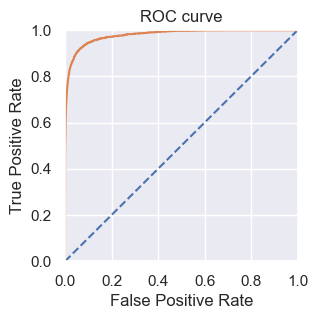

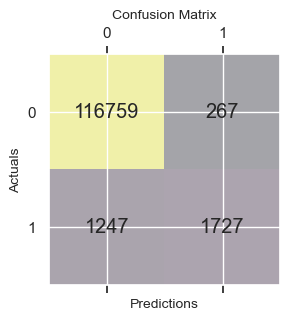

In [53]:
pred = model.predict(X_sample_test)
metrics(y_sample_test, pred, X_sample_test)

### Поиск лучших кондидатов:

In [54]:
def best_candidates_search(df, n, cand_num, type):
    best_candidates_list = []
    for i in tqdm(range((len(df)// n))):
        best_c = df[n*i:n*(i+1)].sort_values(by='prob', ascending=False)[:cand_num]
        best_candidates_list.append(best_c)
        del best_c
    print('lists created...')    
    del df
    gc.collect()
    print('origin DF deleted...')    
    new_df = pd.DataFrame(np.concatenate(best_candidates_list))
    print('new DF created!')
    return new_df

In [55]:
X = np.array(features_train.drop(['target'], axis = 1))
y = np.array(target_train)

In [56]:
X = pd.DataFrame(X)
X['prob'] = model.predict_proba(X)[:, 1]
X['target'] = y

In [57]:
best5_train = best_candidates_search(X, n_neigbours, 5, 'train')

  0%|          | 0/100000 [00:00<?, ?it/s]

lists created...
origin DF deleted...
new DF created!


In [58]:
del X
gc.collect()

0

0.0    0.855304
1.0    0.144696
Name: 147, dtype: float64


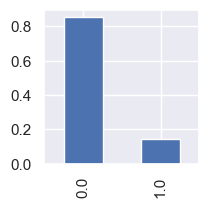

In [59]:
# Оценка дисбаланса классов и построение графика
plt.figure(figsize=(2,2))
class_frequency = best5_train[best5_train.shape[1]-1].value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar'); 

## Загрузка данных valid

In [60]:
features_valid = pd.read_csv(PATH + 'all_features_valid.csv', index_col=0)
target_valid = pd.read_csv(PATH + 'target_valid.csv', index_col=0)
idx_d_valid = pd.read_csv(PATH + 'faiss_idx_and_distances_valid.csv', index_col=0)

In [61]:
features_valid['distance'] = idx_d_valid['1']
features_valid['index'] = idx_d_valid['0']

In [62]:
del idx_d_valid
gc.collect()

2416

### Поиск лучших кондидатов:

In [63]:
features_valid['prob'] = model.predict_proba(features_valid)[:, 1]
features_valid['target'] = target_valid

In [64]:
best5_valid = best_candidates_search(features_valid, n_neigbours, 5, 'valid')

  0%|          | 0/100000 [00:00<?, ?it/s]

lists created...
origin DF deleted...
new DF created!


In [65]:
del features_valid
gc.collect()

0

0.0    0.855688
1.0    0.144312
Name: 147, dtype: float64


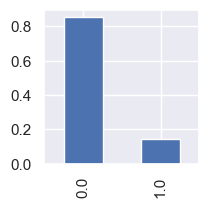

In [66]:
# Оценка дисбаланса классов и построение графика
plt.figure(figsize=(2,2))
class_frequency = best5_valid[best5_valid.shape[1]-1].value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar');  

## CatBoost Classification

### Valid на Train:

In [67]:
y_train = np.array(best5_train[best5_train.shape[1]-1])
X_train = np.array(best5_train.drop([best5_train.shape[1]-1], axis=1))
del best5_train
gc.collect()

2444

In [68]:
y_valid = np.array(best5_valid[best5_valid.shape[1]-1])
X_valid = np.array(best5_valid.drop([best5_valid.shape[1]-1], axis=1))

gc.collect()

0

In [69]:
model = CatBoostClassifier(verbose=500, depth=6, 
                           iterations=1500, 
                           random_seed=13425, 
                           loss_function='Logloss',
                           boosting_type='Ordered')
model.fit(X_train, y_train)

Learning rate set to 0.100906
0:	learn: 0.5624163	total: 399ms	remaining: 9m 58s
500:	learn: 0.1521100	total: 3m 11s	remaining: 6m 22s
1000:	learn: 0.1380484	total: 6m 19s	remaining: 3m 9s
1499:	learn: 0.1289724	total: 9m 25s	remaining: 0us


SHAP:

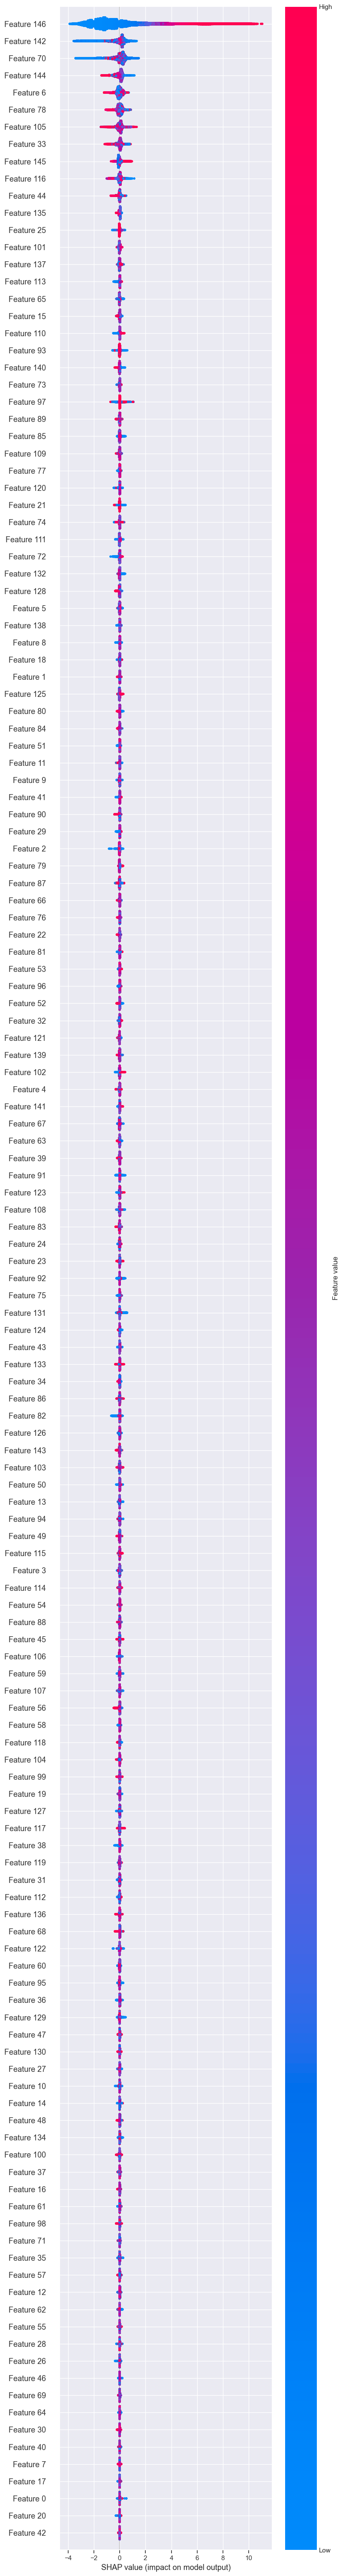

In [70]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train, max_display = 150)

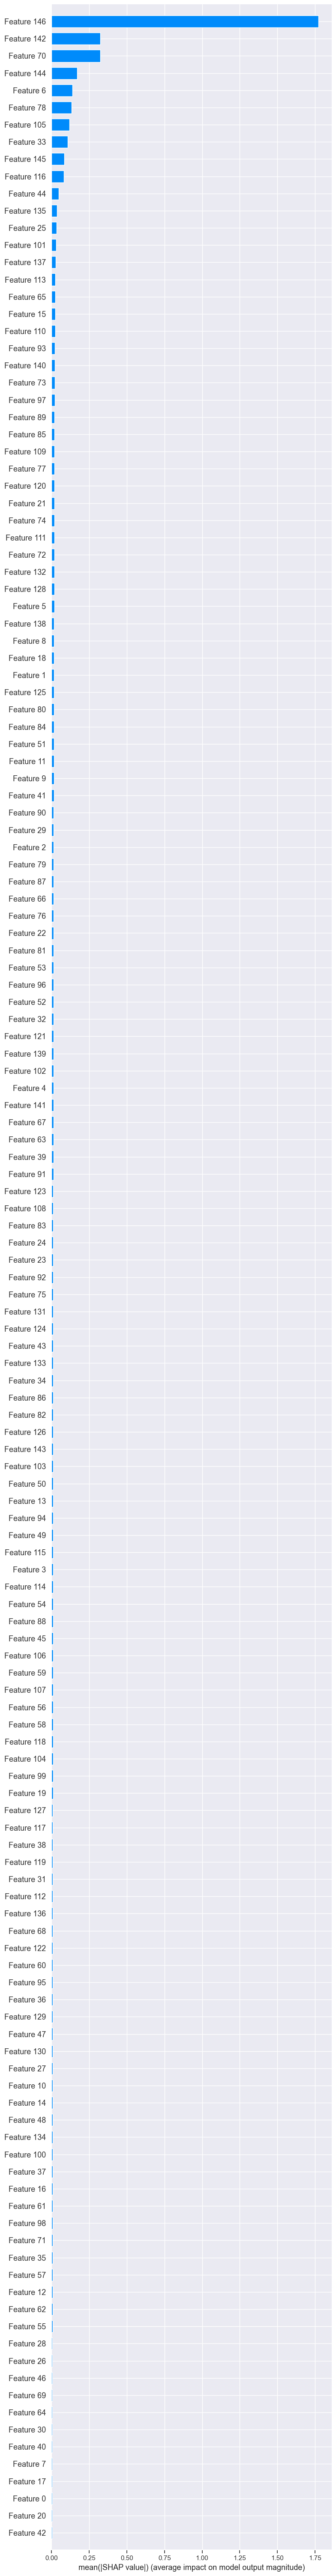

In [71]:
shap.summary_plot(shap_values, X_train, plot_type="bar", max_display = 150)

Все те же расмотренные выше признаки 6, 21, 25, 33, 44, 59, 65, 70 в топе

Accuracy:  0.945
Precision:  0.879
Recall:  0.717
F1-score:  0.79
ROC-AUC:  0.962


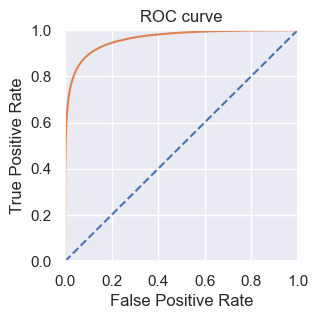

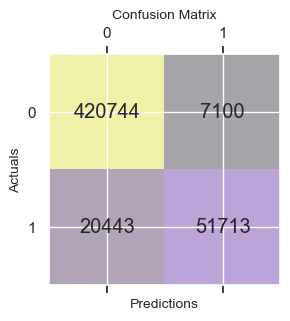

In [72]:
y_pred = model.predict(X_valid)
metrics(y_valid, y_pred, X_valid)

Сравнение с DummyClassifier:

In [73]:
dummy_clf = DummyClassifier(strategy='stratified')
dummy_clf.fit(X_train, y_train)

DummyClassifier(strategy='stratified')

Accuracy:  0.753
Precision:  0.144
Recall:  0.144
F1-score:  0.144
ROC-AUC:  0.962


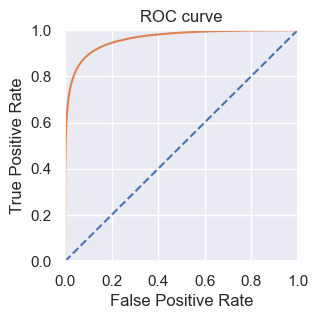

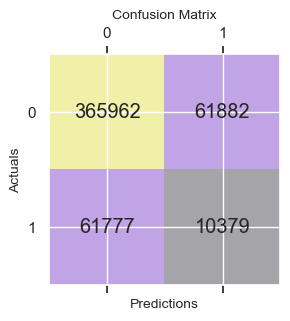

In [74]:
dum_pred = dummy_clf.predict(X_valid)
metrics(y_valid, dum_pred, X_valid)

Для оценки производительности модели использетя оценка F1 и Accuracy. F1 указывает, что модель обладает как высокой точностью, так и высокой отзывчивостью, что означает, что она способна правильно идентифицировать положительные случаи, избегая ложноположительных срабатываний и ложноотрицательных результатов. Модель адекватна и лучше константной.

### Accuracy@5 на validation_answer

In [75]:
targets_valid = pd.read_csv(PATH + 'validation_answer.csv', index_col=0)['Expected']
base_index = open(PATH + 'base_index.txt')
base_index = json.load(base_index)

In [76]:
n=5
best_indexes = []
for i in tqdm(range((len(best5_valid)// n))):
    best_indexes.append(best5_valid[best5_valid.shape[1]-3][n*i:n*(i+1)].tolist())

  0%|          | 0/100000 [00:00<?, ?it/s]

In [77]:
best_indexes_int = []
for i in range(len(best_indexes)):
    l = [int(item) for item in best_indexes[i]]
    best_indexes_int.append(l)

In [78]:
acc =0

for target, el in zip(targets_valid.reset_index(drop=True).values.tolist(), best_indexes_int):
    acc += int(target in [base_index[str(r)] for r in el])   
print('neighbours found: {} %'.format(100 * acc / len(best_indexes_int)))

neighbours found: 72.156 %


## Сохранение модели

In [80]:
model.save_model(PATH + 'matching_model.cbm', format='cbm')

## Вывод

***Вывод:***

Исходные данные имеют хорошее качество. Тип данных - соответствует. Пропуски, дубликаты, выбросы / аномалии - отсутствуют. Разве что, существует "дисбаланс" между значениями. А именно, некоторые значения встречаются особо часто в сравнении со всеми остальными. К примеру: для признака №25 особо популярен значение 813.770071. Оно встречается у ~80% товаров.

Поскольку значения признаков сильно отличаются друг от друга все признаки были отмасштабированы. Это помогло сделать их равнозначными и находить объективные закономерности в дальнейшем.

Было создано и наполнено векторное пространство из объектов датасета `base`. Пространство поделено на 30 кластеров, что ускоряет и уточняет процесс поиска. Для каждого объекта из `train` были найдены 30 ближайших векторов при помощи меры `FlatL2`. Кол-во кластеров выбрано методом локтя.

По результату поиска ближайших соседей для 74.354% новых товара из `train` найдено 30 кандидатов и для 74.334% из `valid`, среди которах есть целевой (т.е. верно подобранный экспертом).

Далее, среди найденных кандидатов были выделены пятерки самых подходящий. Для этого их применялась CatBoostClassifier. Присутствующий негативный эффект дисбаланса классов оставлен. Отмечены все те же признаки [6, 21, 25, 33, 44, 59, 65, 70] влияющие на качество модели.

Итоговое значение целевой метрики 72.156%.

Это значение не конечное и его можно улучшить уделив время на реализацию некоторых из предложенных ниже вариантов.

**Возможные улучшения:**
1. В поиске ближайших соседей в качестве мера близости использовать [другие варианты](https://github.com/facebookresearch/faiss/wiki/Faiss-indexes), к примеру: `IndexFlatIP`и т.д.
2. Решить проблему _дисбаланса классов_.
3. Уделить больше внимания подбору гиперпараметров модели.
4. В ходе эксперемента в попытках удалить части признаков привело к резкому ухудшению модели. Нужно больше эксперементов и удаление по одному. Занимает много времени(((
5. Возможно рассмотреть часть из этих признаков как категориальные.
6. Возможно, заместо простого объединения векторов (конкатенации), стоит выполнить между ними вычисления и получить новый перечень признаков.


**P.S.** Я постарался выполнить полностью техническую часть проекта, т.е.: масштабирование данных, поиск ближайших соседей, ранжирование данных, оценка результата предсказаний. Дело остаётся за модернизации уже имеющегося процесса, подбор параметров. К сожалению, мне не удалось реализовать это к сроку сдачи проекта, но я планирую закончить проект после. Именно по этому я подробно описал возможности по его улучшению.